# CITS5508 Lab 3: Classification on Forest Type

Name: Joey Koh<br>
Student number: 21506379  
Date created: 13 April 2020  
Last modified: 20 April 2020  

This notebook goes through the steps of a typical ensemble classifier (voting classifier) project. It is addressing a multi-class classification task on predicting protein localisation sites using various attributes for E.coli.<br>

A Support Vector Machine Classifier, Logistic Regression, and Gradient Descent Classifier are used in ensemble and judged in performance.

- [ ] fix notes
- [ ] search and fix EDIT

ask:
- how to use drop/loc
- feature scaling using training_x data right?
- accuracy and f1 score difference?

## 1. Setup, Data Loading and Visualisation
Import libraries to be used and bring the data in.<br>
Perform basic visualisations to have a feel of data. <br>

In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
#Use jupyter's backend to render plots
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

from pandas.plotting import scatter_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import VotingClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn import metrics

#Prepare the data, separate cols by whitespace, give col names
raw_data = pd.read_csv("ecoli.data", delim_whitespace = True, header=None, names=['sequence name','mcg','gvh','lip','chg','aac','alm1','alm2','class'])

#View first few lines and inspect columns
raw_data.head()

,sequence name,mcg,gvh,lip,chg,aac,alm1,alm2,class
0,AAT_ECOLI,0.49,0.29,0.48,0.5,0.56,0.24,0.35,cp
1,ACEA_ECOLI,0.07,0.40,0.48,0.5,0.54,0.35,0.44,cp
2,ACEK_ECOLI,0.56,0.40,0.48,0.5,0.49,0.37,0.46,cp
3,ACKA_ECOLI,0.59,0.49,0.48,0.5,0.52,0.45,0.36,cp
4,ADI_ECOLI,0.23,0.32,0.48,0.5,0.55,0.25,0.35,cp


These are the first **few lines of data.** Note the **new** column headings.<br>
Looks good, columns are named. We know the first 8 columns are features with the 9th being the class label.

In [2]:
#Look at class distribution
raw_data["class"].value_counts()   #Count instances for class labels

cp     143
im      77
pp      52
imU     35
om      20
omL      5
imS      2
imL      2
Name: class, dtype: int64

In [3]:
#with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#    print(raw_data)

In [4]:
#Let's remove class labels with less than 10 instances as it is impossible to classify them
#i.e. remove all rows with class= ["imS","imL","omL"]
def clean_data(df): #remove low class instances
    c_df = df[ (df["class"]!="imS") & (df["class"]!="imL") & (df["class"]!="omL") ] #remove rows with class= ["imS","imL","omL"]
    c_df = c_df.reset_index(drop=True) #renumber index
    print("are there any NaN values created?")
    print(c_df.isnull().values.any()) #ensure no undefined values due to removal
    return c_df

data = clean_data(raw_data)
data.describe() #get an idea of data distribution


are there any NaN values created?
False


,mcg,gvh,lip,chg,aac,alm1,alm2
count,327.000000,327.000000,327.000000,327.0,327.000000,327.000000,327.000000
mean,0.494190,0.499939,0.484771,0.5,0.499450,0.497462,0.503119
std,0.193719,0.149935,0.049654,0.0,0.123165,0.217333,0.206947
min,0.000000,0.160000,0.480000,0.5,0.000000,0.030000,0.000000
25%,0.340000,0.400000,0.480000,0.5,0.420000,0.330000,0.350000
50%,0.490000,0.470000,0.480000,0.5,0.490000,0.450000,0.430000
75%,0.655000,0.570000,0.480000,0.5,0.570000,0.710000,0.710000
max,0.890000,1.000000,1.000000,0.5,0.880000,1.000000,0.990000


Good to see they all have equal numbers of instances

In [5]:
#with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#   print(data)

In [6]:
data.head()

,sequence name,mcg,gvh,lip,chg,aac,alm1,alm2,class
0,AAT_ECOLI,0.49,0.29,0.48,0.5,0.56,0.24,0.35,cp
1,ACEA_ECOLI,0.07,0.40,0.48,0.5,0.54,0.35,0.44,cp
2,ACEK_ECOLI,0.56,0.40,0.48,0.5,0.49,0.37,0.46,cp
3,ACKA_ECOLI,0.59,0.49,0.48,0.5,0.52,0.45,0.36,cp
4,ADI_ECOLI,0.23,0.32,0.48,0.5,0.55,0.25,0.35,cp


### 1.1 Visualisations

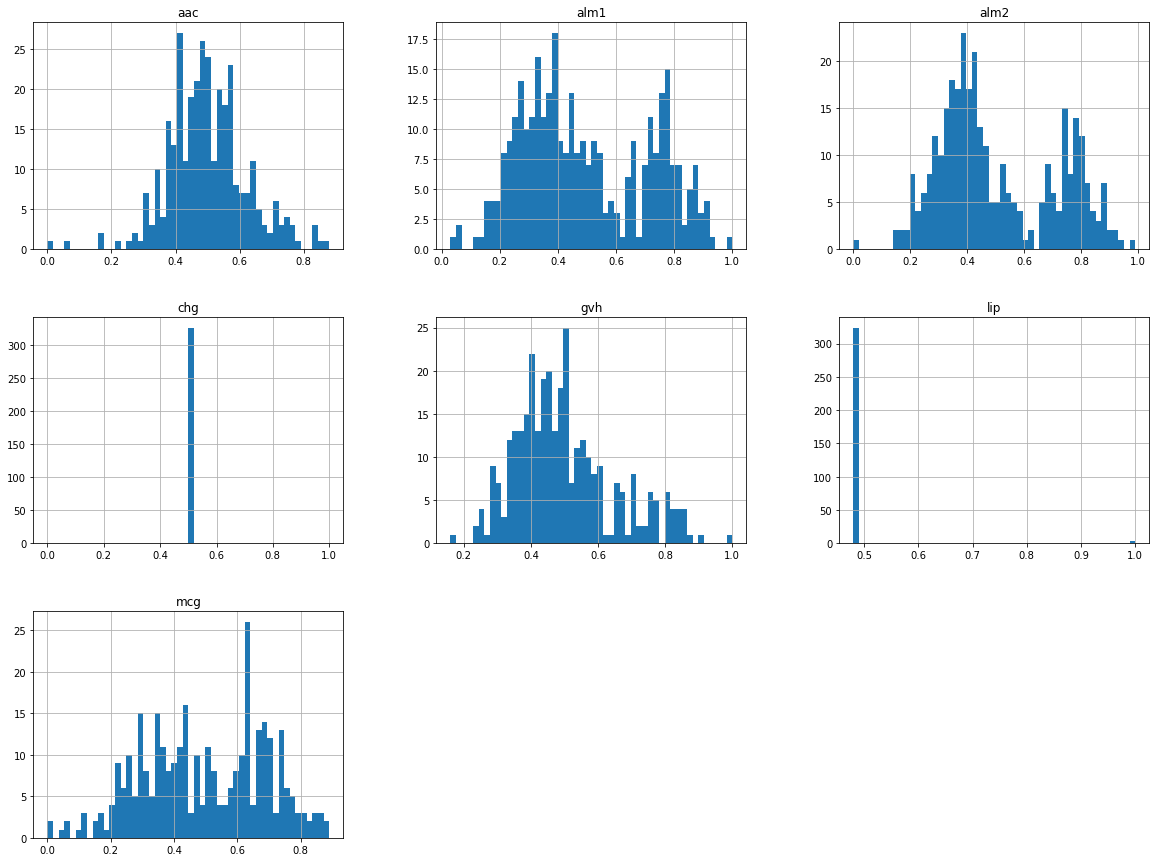

In [7]:
#Generate histograms
data.hist(bins=50, figsize=(20,15))
plt.show()

EDIT From these histograms of the training data, it can be observed that:<br>
* Most attributes are normally distributed
* The attributes have different scales, hence we would likely need feature scaling
* Most b1-b9 attributes are tail-heavy. They extend much further to the right of the median than left.
* Most pred_minus_obs_H b1 to b9 attributes are head-heavy. They extend much further to the left of median than right.
* Most pred_minus_obs_S b1 to b9 attributes are normally distributed around the middle of its range
* Approximating the median for each attribute to be around the middle of the normal distribution hump, the far tails/heads values could potentially be outliers. It might be better to use StandardScaler rather than MinMaxScaler in data normalisation due to outliers.

In [8]:
#data.apply(pd.value_counts).plot(kind='bar', subplots=True)


In [9]:
print("These are the number of unique categories in 'sequence name' feature:")
print(data["sequence name"].nunique())
print("These are the number of unique values in 'chg' feature:")
print(data["chg"].nunique())
print("These are the number of unique values in 'lip' feature:")
print(data["lip"].nunique())



These are the number of unique categories in 'sequence name' feature:
327
These are the number of unique values in 'chg' feature:
1
These are the number of unique values in 'lip' feature:
2


- "sequence name" matches the data's total number of instances
- "chg" values are identical
- "lip" looks like it has an outlier <br>
Hence we could consider dropping this and  EDIT

In [10]:
data.columns

Index(['sequence name', 'mcg', 'gvh', 'lip', 'chg', 'aac', 'alm1', 'alm2',
       'class'],
      dtype='object')

In [11]:
#try dropping seq name col
data= data.drop("sequence name", axis=1)
data.head()

,mcg,gvh,lip,chg,aac,alm1,alm2,class
0,0.49,0.29,0.48,0.5,0.56,0.24,0.35,cp
1,0.07,0.40,0.48,0.5,0.54,0.35,0.44,cp
2,0.56,0.40,0.48,0.5,0.49,0.37,0.46,cp
3,0.59,0.49,0.48,0.5,0.52,0.45,0.36,cp
4,0.23,0.32,0.48,0.5,0.55,0.25,0.35,cp


## 2. Pipeline: Data Cleaning, Checking and Normalisation
Remove unneeded columns, extract labels, check for training set balance, perform feature scaling, and create pipeline.

In [12]:
#EDIT? stratified shuffling?
from sklearn.model_selection import train_test_split
#Split dataset at 8:2 ratio
train_data, test_data = train_test_split(data, test_size=0.2, random_state= 42)
#Ensure no NaN values
print("are there any NaN values created for test data and train data?")
print(test_data.isnull().values.any()," and ",train_data.isnull().values.any() )




are there any NaN values created for test data and train data?
False  and  False


As checked, there are no undefined values after data splitting.

In [13]:
def separate_pipeline(df): #separate data into labels and predictors
    df_y = df["class"]  #Extract class labels
    print("For this dataset, these are the number of instances for each class label")
    print(df_y.value_counts(),"\n")   #Count instances for class labels in training set
    df_x = df.drop("class", axis=1) #separate predictors from labels
    print(df_x.describe(),'\n')  #get an idea of the data distribution
    return df_y, df_x

def scaler_pipeline(df,df_train_x): #for data normalisation
    std_scaler = StandardScaler()
    std_scaler.fit(df_train_x)
    return std_scaler.transform(df)
    
def main_pipeline(train_dataset, test_dataset):
    print("For the training dataset:\n")
    train_y, train_x = separate_pipeline(train_dataset)
    print("For the testing dataset:\n")
    test_y, test_x = separate_pipeline(test_dataset)
    train_x_tr = scaler_pipeline(train_x, train_x)
    test_x_tr = scaler_pipeline(test_x, train_x)
    return train_y, train_x, test_y, test_x, train_x_tr, test_x_tr

train_y, train_x, test_y, test_x, train_x_tr, test_x_tr = main_pipeline(train_data, test_data)


For the training dataset:

For this dataset, these are the number of instances for each class label
cp     113
im      62
pp      40
imU     29
om      17
Name: class, dtype: int64 

              mcg         gvh         lip    chg         aac        alm1  \
count  261.000000  261.000000  261.000000  261.0  261.000000  261.000000   
mean     0.495172    0.501533    0.485977    0.5    0.499425    0.498927   
std      0.197659    0.153945    0.055535    0.0    0.125122    0.220429   
min      0.000000    0.160000    0.480000    0.5    0.000000    0.030000   
25%      0.340000    0.400000    0.480000    0.5    0.420000    0.320000   
50%      0.500000    0.470000    0.480000    0.5    0.490000    0.450000   
75%      0.650000    0.570000    0.480000    0.5    0.570000    0.710000   
max      0.890000    1.000000    1.000000    0.5    0.880000    1.000000   

             alm2  
count  261.000000  
mean     0.501992  
std      0.209917  
min      0.000000  
25%      0.350000  
50%      0.4

<p>From looking at the count of class instances of training data, <b>we clearly have an imbalanced training dataset.</b> With 's' and 'd' classes having the most instances of 136 and 105 respectively, relative to 'o' and 'h' classes of 46 and 38 respectively.</p>

<p>(Class: 's' ('Sugi' forest), 'h' ('Hinoki' forest), 'd' ('Mixed deciduous' forest), 'o' ('Other' non-forest land) </p>
<p>Looking at the distribution of the values at min, 25%, 50%, 75% and max – in combination to the observations from the histograms in Section 1.1, there are likely <b>outliers in training predictors</b> which a <b>StandardScaler</b> would deal better with compared to a MinMaxScaler. For this reason, standardization was used in the pipeline to normalise the data. In this, firstly the column's mean value is subtracted from every value in the column, then divided by the standard deviation. The resulting distribution has unit variance. Thus, the outliers has less of an impact compared to MinMax scaling.</p>

## 3. Support Vector Classifier
one vs one binary classication

In [14]:
#fit SVC model with training data
svm_clf = SVC()
svm_clf.fit(train_x_tr,train_y);

#generate test data label prediction
test_y_svm_pred = svm_clf.predict(test_x_tr)

/Users/Joey/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


### 3.1 Confusion Matrix 

In [15]:
def conf_matrix(actual_y, pred_y, model): #confusion matrix function for plotting
    #confusion matrix generation
    conf_mx = confusion_matrix(actual_y, pred_y)
    print("This is the confusion matrix for",model,"\n",conf_mx)

    #visualisation setup
    alpha = ['cp', 'im', 'imU', 'om','pp']
    conf_data = conf_mx

    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(conf_data, interpolation='nearest')
    fig.colorbar(cax)

    ax.set_xticklabels(['']+alpha)
    ax.set_yticklabels(['']+alpha)

    plt.show
    print("Plotting with predicted test dataset labels on horizontal axis, actuals labels on vertical axis")
    
def report_scores(actual_y, pred_y): #accuracy and F1 score function
    print("Accuracy score of prediction:\n")
    print(metrics.accuracy_score(actual_y, pred_y),"\n")
    print("F1 scores of prediction for each class:")
    #print("in order of ['cp', 'im', 'imU', 'om','pp']\n")
    print(metrics.f1_score(actual_y, pred_y, average= "micro"))
    

This is the confusion matrix for SVC 
 [[30  0  0  0  0]
 [ 1 13  1  0  0]
 [ 0  3  3  0  0]
 [ 0  0  0  3  0]
 [ 1  0  0  0 11]]
Plotting with predicted test dataset labels on horizontal axis, actuals labels on vertical axis


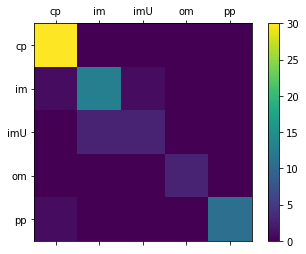

In [16]:
#Confusion matrix for SVC
conf_matrix(test_y,test_y_svm_pred, "SVC")

**Results:** Each row represents an actual class, while each column represents a predicted class. The classification results are thus:
* Class cp: 53 correctly predicted, 1 wrongly predicted as 'o'
* Class im: 39 correctly predicted, 9 wrongly predicted as 's'
* Class imU: 34 correctly predicted, 3 wrongly predicted as 'd'
* Class om: 56 correctly predicted, 1,2 wrongly predicted as 'd','h' respectively
* Class pp: 56 correctly predicted, 1,2 wrongly predicted as 'd','h' respectively

In [17]:
report_scores(test_y, test_y_svm_pred)

Accuracy score of prediction:

0.9090909090909091 

F1 scores of prediction for each class:
0.9090909090909091


### 3.2 Tune Hyperparameters with Grid Search

In [18]:
param_grid = {'kernel':('linear', 'rbf', 'poly'), 
              'C':[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
              'gamma':['scale','auto']
             }

svm_clf = SVC()
scorer = sk.metrics.make_scorer(sk.metrics.f1_score, average = 'micro')

grid_search_svm = GridSearchCV(svm_clf, 
                               param_grid, 
                               scoring = scorer,
                               return_train_score = True)

grid_result_svm = grid_search_svm.fit(train_x_tr, train_y)

/Users/Joey/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/Joey/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [19]:
print('Best Score: ', grid_result_svm.best_score_)
print('Best Params: ', grid_result_svm.best_params_)

Best Score:  0.8850574712643678
Best Params:  {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}


**Results:** looking up the SVC documentation, the best hyperparameters from the gridsearch matches the default settings of the classifier. Hence, it will be left as unchanged.

In [20]:
test_y_svm_pred_tuned = grid_result_svm.predict(test_x_tr) #Get predictions from grid search result

### 3.3 Confusion Matrix after Grid Search

This is the confusion matrix for SVC tuned 
 [[29  0  0  0  1]
 [ 1 14  0  0  0]
 [ 0  2  4  0  0]
 [ 0  0  0  3  0]
 [ 1  0  0  0 11]]
Plotting with predicted test dataset labels on horizontal axis, actuals labels on vertical axis


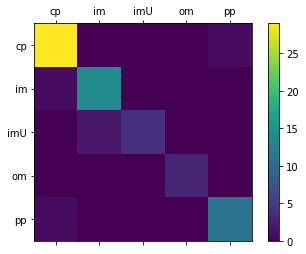

In [21]:
#confusion matrix generation
conf_matrix(test_y, test_y_svm_pred_tuned, "SVC tuned")

**Results:** Each row represents an actual class, while each column represents a predicted class. The classification results are thus:
* Class d: 53 correctly predicted, 1 wrongly predicted as 'o'
* Class h: 39 correctly predicted, 9 wrongly predicted as 's'
* Class o: 34 correctly predicted, 3 wrongly predicted as 'd'
* Class s: 56 correctly predicted, 1,2 wrongly predicted as 'd','h' respectively

In [22]:
report_scores(test_y, test_y_svm_pred_tuned)

Accuracy score of prediction:

0.9242424242424242 

F1 scores of prediction for each class:
0.9242424242424242


As the gridsearch results indicate default hyperparameter values are the best in the tested range of values, the accuracy score and confusion matrix **matches** the un-tuned version's.

## 4. Logistic Regression Classifier

In [23]:
#fit log regression model with training data
log_clf = LogisticRegression()
log_clf.fit(train_x_tr, train_y)

#get test data label predictions
test_y_log_pred = log_clf.predict(test_x_tr)

/Users/Joey/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/Joey/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


This is the confusion matrix for log regression 
 [[30  0  0  0  0]
 [ 1 14  0  0  0]
 [ 0  1  4  0  1]
 [ 0  0  0  3  0]
 [ 1  0  0  0 11]]
Plotting with predicted test dataset labels on horizontal axis, actuals labels on vertical axis


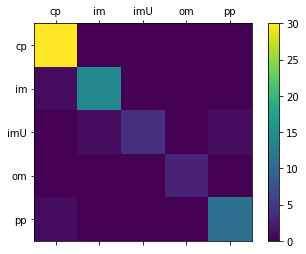

In [24]:
conf_matrix(test_y, test_y_log_pred, "log regression")

Results? EDIT

In [25]:
report_scores(test_y, test_y_log_pred)

Accuracy score of prediction:

0.9393939393939394 

F1 scores of prediction for each class:
0.9393939393939394


## 5. Stochastic Gradient Descent Classifier

In [26]:
#fit SGD model with training data
sgd_clf = SGDClassifier()
sgd_clf.fit(train_x_tr, train_y);

#generate test data label prediction
test_y_sgd_pred = sgd_clf.predict(test_x_tr)

### 5.1 Confusion Matrix 

This is the confusion matrix for SGD 
 [[29  0  0  0  1]
 [ 1 14  0  0  0]
 [ 0  2  4  0  0]
 [ 0  0  0  3  0]
 [ 2  0  0  0 10]]
Plotting with predicted test dataset labels on horizontal axis, actuals labels on vertical axis


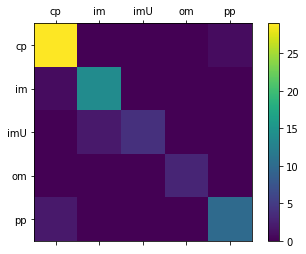

In [27]:
#confusion matrix generation
conf_matrix(test_y, test_y_sgd_pred, "SGD")

**Results:** Each row represents an actual class, while each column represents a predicted class. The classification results are thus:
* Class d: 53 correctly predicted, 1 wrongly predicted as 'o' 
* Class h: 43 correctly predicted, 5 wrongly predicted as 's' 
* Class o: 36 correctly predicted, 1 wrongly predicted as 'd'
* Class s: 53 correctly predicted, 5,1 wrongly predicted as 'h','o' respectively

In [28]:
report_scores(test_y, test_y_sgd_pred)

Accuracy score of prediction:

0.9090909090909091 

F1 scores of prediction for each class:
0.9090909090909091


### 5.2 Tune Hyperparameters with Grid Search

In [29]:
param_grid = {'loss':('hinge', 'log', 'modified_huber', 'perceptron'), 
              'alpha':[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
              'penalty':['l2','l1','elasticnet']
             }

sgd_clf = SGDClassifier()
scorer = sk.metrics.make_scorer(sk.metrics.f1_score, average = 'micro')

grid_search_sgd = GridSearchCV(sgd_clf, 
                               param_grid, 
                               scoring = scorer,
                               return_train_score = True)

grid_result_sgd = grid_search_sgd.fit(train_x_tr, train_y)

/Users/Joey/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/Joey/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [30]:
print('Best Score: ', grid_result_sgd.best_score_)
print('Best Params: ', grid_result_sgd.best_params_)

Best Score:  0.8812260536398467
Best Params:  {'alpha': 0.01, 'loss': 'log', 'penalty': 'l1'}


**Results:** looking up the SGDClassifier documentation, the default hyperparameters would be {'alpha': 0.0001, 'loss': 'hinge', 'penalty': 'l2'}. As the grid search result is not identical, we should expect a better performance from the tuned settings. Hence, the accuracy and confusion matrix should be different.

In [31]:
test_y_sgd_pred_tuned = grid_result_sgd.predict(test_x_tr) #Get predictions from grid search result

### 5.3 Confusion Matrix after Grid Search

This is the confusion matrix for SGD tuned 
 [[30  0  0  0  0]
 [ 1 14  0  0  0]
 [ 0  1  4  0  1]
 [ 0  0  0  3  0]
 [ 1  0  0  0 11]]
Plotting with predicted test dataset labels on horizontal axis, actuals labels on vertical axis


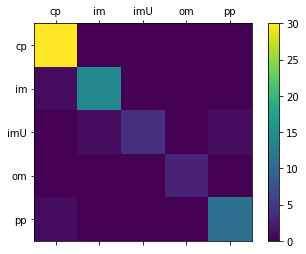

In [32]:
#confusion matrix generation
conf_matrix(test_y, test_y_sgd_pred_tuned, "SGD tuned")

**Results:** Each row represents an actual class, while each column represents a predicted class. The classification results are thus:
* Class d: 53 correctly predicted, 1 wrongly predicted as 'o'
* Class h: 38 correctly predicted, 1,9 wrongly predicted as 'd','s' respectively
* Class o: 32 correctly predicted, 5 wrongly predicted as 'd'
* Class s: 57 correctly predicted, 1,1 wrongly predicted as 'h','o' respectively

In [33]:
report_scores(test_y,test_y_sgd_pred_tuned)

Accuracy score of prediction:

0.9393939393939394 

F1 scores of prediction for each class:
0.9393939393939394


## 6. Voting Classifier

In [34]:
#create and fit training data with voting classifier
voting_clf = VotingClassifier(
    estimators=[('svc', svm_clf), ('lr', log_clf), ('sgd', sgd_clf)],
    voting='hard')
voting_clf.fit(train_x_tr, train_y)

#generate test data label prediction
test_y_voting_pred = voting_clf.predict(test_x_tr)

/Users/Joey/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/Joey/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/Joey/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [45]:
#Check each classfier's accuracy scores used in voting_clf
for clf in (svm_clf, log_clf, sgd_clf, voting_clf):
    clf.fit(train_x_tr, train_y)
    checking_y_pred = clf.predict(test_x_tr)
    print(clf.__class__.__name__, sk.metrics.accuracy_score(test_y, checking_y_pred))

SVC 0.9090909090909091
LogisticRegression 0.9393939393939394
SGDClassifier 0.8636363636363636
VotingClassifier 0.9090909090909091


/Users/Joey/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/Joey/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/Joey/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Users/Joey/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for

This is the confusion matrix for voting classifier 
 [[30  0  0  0  0]
 [ 1 14  0  0  0]
 [ 0  3  3  0  0]
 [ 0  0  0  3  0]
 [ 1  0  0  0 11]]
Plotting with predicted test dataset labels on horizontal axis, actuals labels on vertical axis


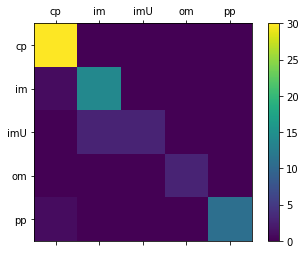

In [46]:
#generate confusion matrix
conf_matrix(test_y, test_y_voting_pred, "voting classifier")

Results

In [37]:
report_scores(test_y, test_y_voting_pred)

Accuracy score of prediction:

0.9242424242424242 

F1 scores of prediction for each class:
0.9242424242424242


## 7. Conclusion

<p>The accuracy score of the untuned and tuned Support Vector Classifier were identical, at 91.9%. This was due to the hyperparameters from the grid search matching the default hyperparameters.</p>

<p>The accuracy score of the untuned Stochastic Gradient Descent Classifier was 93.4%, while the tuned version had a score of 90.9%. As the grid search's resulting hyperparameters were not identical to the default settings, this change is expected. The accuracy score, and thus performance, was found to be lower. However, this is due to the system ending up fine-tuned to perform well on the validation data and it is unlikely to perform as well on unknown datasets. Trying to manually tweak the parameters to make the performance look good on the test dataset would result in the changes being unlikely to generalise well with any new data.
</p>

<p>Overall, the performance of the Support Vector Classifier is comparable to the Stochastic Gradient Descent Classifier.</p>